In [1]:
import pandas as pd

df = pd.read_csv('mbti_1.csv')
print(df.head())


   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [2]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)     # remove links
    text = re.sub(r'[^A-Za-z ]+', '', text) # remove numbers/punctuation
    text = text.lower()
    return text

df['clean_posts'] = df['posts'].apply(clean_text)


In [3]:
df

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten ...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know tha...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,just because i always think of cats as fi dom...
8671,ENFP,'So...if this thread already exists someplace ...,soif this thread already exists someplace else...
8672,INTP,'So many questions when i do these things. I ...,so many questions when i do these things i wo...
8673,INFP,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...


In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# MBTI types and cognitive functions
mbti_types = [t.lower() for t in [
    'INFJ', 'INFP', 'INTP', 'INTJ', 'ENFP', 'ENFJ', 'ENTP', 'ENTJ',
    'ISFP', 'ISFJ', 'ISTP', 'ISTJ', 'ESFP', 'ESFJ', 'ESTP', 'ESTJ'
]]
functions = [f.lower() for f in ['Fi', 'Fe', 'Ti', 'Te', 'Ni', 'Ne', 'Si', 'Se']]

# Extra junk words you may want to remove
junk_words = set([
    'ur', 'u', 'youre', 'im', 'ive', 'dont', 'doesnt', 'didnt', 'cant', 'wont', 'sofi', 'mbti'
])

def super_clean(text):
    text = text.lower()                                  # Lowercase
    text = re.sub(r'http\S+', '', text)                  # Remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text)                # Remove punctuation and digits
    words = text.split()

    # Remove MBTI types, functions, stopwords, and junk words
    words = [w for w in words if w not in mbti_types
             and w not in functions
             and w not in stop_words
             and w not in junk_words
             and len(w) > 2]                             # Remove very short words (like "fi", "i", "we")

    text = ' '.join(words)
    return text


df['clean_posts'] = df['posts'].apply(super_clean)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moments sportscenter top ten plays pranks life...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack posts alarming sex boring positio...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing curse absolu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gabbing...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approaching ...


In [5]:
df.drop(columns=['posts'], inplace=True)
df.head()

,type,clean_posts
0,INFJ,moments sportscenter top ten plays pranks life...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear enjoyed conversation day esoteric gabbing...
4,ENTJ,fired another silly misconception approaching ...


In [6]:
df.shape

(8675, 2)

In [7]:
def get_binary_labels(mbti_type):
    return {
        'IE': 0 if mbti_type[0] == 'I' else 1,
        'NS': 0 if mbti_type[1] == 'N' else 1,
        'TF': 0 if mbti_type[2] == 'T' else 1,
        'JP': 0 if mbti_type[3] == 'J' else 1,
    }

labels = df['type'].apply(get_binary_labels)
label_df = pd.DataFrame(labels.tolist())
df = pd.concat([df, label_df], axis=1)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_posts'])


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# I vs E model
y = df['IE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_IE = LogisticRegression()
clf_IE.fit(X_train, y_train)

y_pred = clf_IE.predict(X_test)
print("IE Classification Report:")
print(classification_report(y_test, y_pred))


IE Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1353
           1       0.78      0.24      0.36       382

    accuracy                           0.82      1735
   macro avg       0.80      0.61      0.63      1735
weighted avg       0.81      0.82      0.78      1735



In [10]:
# Utility function for training all 4
def train_binary_classifier(X, y_label):
    X_train, X_test, y_train, y_test = train_test_split(X, df[y_label], test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{y_label} Classification Report:")
    print(classification_report(y_test, y_pred))
    return model

clf_IE = train_binary_classifier(X, 'IE')
clf_NS = train_binary_classifier(X, 'NS')
clf_TF = train_binary_classifier(X, 'TF')
clf_JP = train_binary_classifier(X, 'JP')



IE Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1353
           1       0.78      0.24      0.36       382

    accuracy                           0.82      1735
   macro avg       0.80      0.61      0.63      1735
weighted avg       0.81      0.82      0.78      1735


NS Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1489
           1       0.91      0.04      0.08       246

    accuracy                           0.86      1735
   macro avg       0.89      0.52      0.50      1735
weighted avg       0.87      0.86      0.81      1735


TF Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       798
           1       0.80      0.84      0.82       937

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80    

In [11]:
def predict_mbti(text):
    cleaned = super_clean(text)
    vec = vectorizer.transform([cleaned])

    ie = clf_IE.predict(vec)[0]
    ns = clf_NS.predict(vec)[0]
    tf = clf_TF.predict(vec)[0]
    jp = clf_JP.predict(vec)[0]

    mbti = f"{'I' if ie==0 else 'E'}{'N' if ns==0 else 'S'}{'T' if tf==0 else 'F'}{'J' if jp==0 else 'P'}"
    return mbti


In [12]:
whatsapp_text = "I like working on ideas, and prefer alone time. Planning is good but I keep it flexible."
print("Predicted MBTI:", predict_mbti(whatsapp_text))


Predicted MBTI: INTP


In [14]:
# Clean and vectorize the text outside the function if you want to use the 'vec' variable later
cleaned_text = super_clean(whatsapp_text)
vec = vectorizer.transform([cleaned_text]) # Define vec here

proba_ie = clf_IE.predict_proba(vec)[0]
print(f"I: {proba_ie[0]*100:.2f}% | E: {proba_ie[1]*100:.2f}%")

I: 68.92% | E: 31.08%


In [16]:
vec = vectorizer.transform([super_clean(whatsapp_text)])

probs = {
    "IE": clf_IE.predict_proba(vec)[0],
    "NS": clf_NS.predict_proba(vec)[0],
    "TF": clf_TF.predict_proba(vec)[0],
    "JP": clf_JP.predict_proba(vec)[0],
}

# Format display
print(f"I: {probs['IE'][0]*100:.2f}% | E: {probs['IE'][1]*100:.2f}%")
print(f"N: {probs['NS'][0]*100:.2f}% | S: {probs['NS'][1]*100:.2f}%")
print(f"T: {probs['TF'][0]*100:.2f}% | F: {probs['TF'][1]*100:.2f}%")
print(f"J: {probs['JP'][0]*100:.2f}% | P: {probs['JP'][1]*100:.2f}%")


I: 68.92% | E: 31.08%
N: 75.45% | S: 24.55%
T: 74.80% | F: 25.20%
J: 39.56% | P: 60.44%


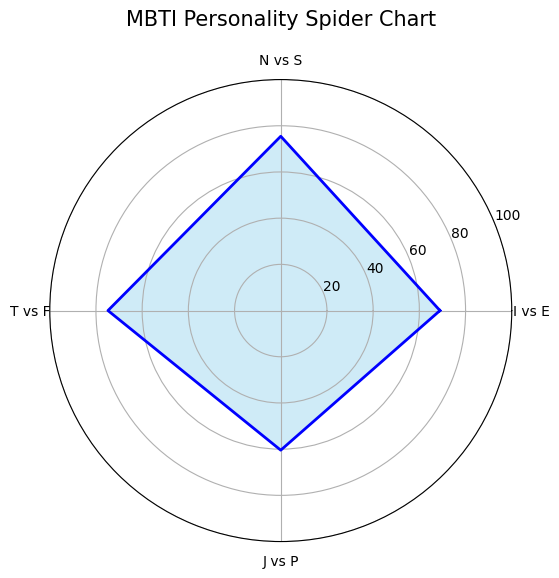

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Values (percentage for dominant trait in each dimension)
labels = ['I vs E', 'N vs S', 'T vs F', 'J vs P']
values = [68.92, 75.45, 74.80, 60.44]

# Number of variables
num_vars = len(labels)

# Compute angle for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made by completing the loop, so append the start value to the end
values += values[:1]
angles += angles[:1]

# Setup the radar plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

# Draw the outline of the spider chart
ax.plot(angles, values, color='blue', linewidth=2)
ax.fill(angles, values, color='skyblue', alpha=0.4)

# Fix axis to go from 0 to 100
ax.set_ylim(0, 100)

# Set labels on each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add title
ax.set_title('MBTI Personality Spider Chart', size=15, y=1.1)

plt.show()
